# 掛載Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cifar10 with CNN

In [16]:
!pip install tensorflow-addons
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(
    f"{X_train.shape}\n"
    f"{y_train.shape}\n"
    f"{X_test.shape}\n"
    f"{y_test.shape}"
)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


# 設定分類名稱

In [3]:
class_name = ["飛機", "汽車", "鳥", "貓", "鹿",
        "狗", "青蛙", "馬", "船", "卡車"]

# CoLab顯示中文

In [4]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 

# 自定義字體變數
myfont = FontProperties(fname=r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

# !!!!後續在相關函式中增加fontproperties=myfont屬性即可!!!!

--2021-05-20 06:47:35--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.141.138, 142.250.141.113, 142.250.141.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0c2qqapsrhvj1nb6lr8n15e75kq7gimm/1621493250000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-05-20 06:47:38--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0c2qqapsrhvj1nb6lr8n15e75kq7gimm/1621493250000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 172.217.3.1, 2607:f8b0:4026:800::2001
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|172

# 展示前25張圖片

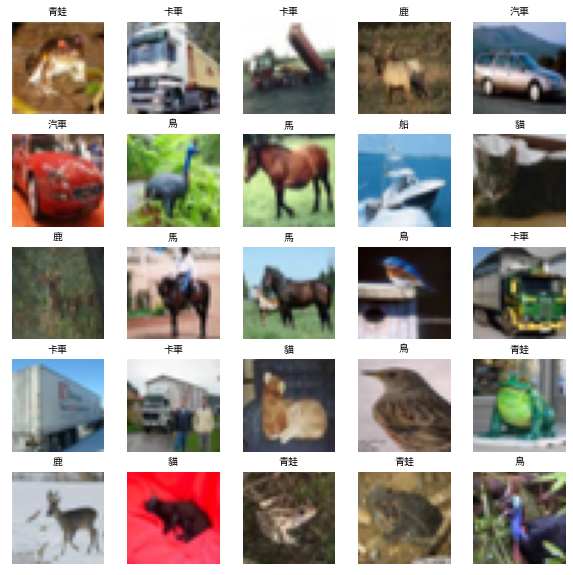

In [15]:
plt.figure(figsize=(10,10))
#plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
#plt.rcParams['axes.unicode_minus'] = False
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i])
    plt.title(class_name[y_train[i][0]], fontproperties=myfont)
plt.show()

# 資料預處理
* Normalize圖片RGB由255降到0-1間

In [6]:
img_size = X_train.shape[1]
X_train = X_train /255
X_test = X_test /255

# 設定儲存最佳模型參數、提早停止模型訓練、儲存History

In [7]:
import os
model_dir = '/content/drive/MyDrive/Colab Notebooks/Cifar10'
file_name = "Cifar10-best-model"
modelfile = f"{model_dir}/{file_name}.h5"
logfile = f"{model_dir}/{file_name}_training.log"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)
model_chpo = keras.callbacks.ModelCheckpoint(modelfile, monitor='val_accuracy', save_best_only=True)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
csv_logger = keras.callbacks.CSVLogger(logfile)
callbacks_list = [model_chpo, earlystop, csv_logger]

# 建立模型
* Conv_1 Param：3x3(Kernel_size) x 3(RGB) x 64(filters) + 64(bias) = 1792
* Conv_2 Param：3x3(Kernel_size) x 64(RGB) x 64(filters) + 64(bias) = 36928
* Conv_3 Param：3x3(Kernel_size) x 64(前一層64個特徵) x 128(filters) + 128(bias) = 73856
* Conv_4 Param：3x3(Kernel_size) x 128(前一層128個特徵) x 128(filters) + 128(bias) = 147584
* Dense_1 Param：8192(前一層輸入神經元總數) x 256(units) + 256(bias) = 2097408
* Dense_2 Param：256(前一層輸入神經元總數) x 256(units) + 256(bias) = 65792
* Dense_3 Param：256(前一層輸入神經元總數) x 10(輸出class) + 10(bias) = 2570

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
cnn = Sequential()
cnn.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu', input_shape=(img_size, img_size, 3)))
cnn.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2), strides=2))
#cnn.add(BatchNormalization())
cnn.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
cnn.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2), strides=2))
#cnn.add(BatchNormalization())
cnn.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu'))
cnn.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu'))
cnn.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2), strides=2))
#cnn.add(BatchNormalization())
#cnn.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation='relu'))
#cnn.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation='relu'))
#cnn.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation='relu'))
#cnn.add(MaxPool2D(pool_size=(2,2), strides=2))
#cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Flatten())
cnn.add(Dense(units=512, activation='relu'))
cnn.add(Dense(units=256, activation='relu'))
cnn.add(Dense(units=128, activation='relu'))
#cnn.add(BatchNormalization())
cnn.add(Dense(units=10, activation='softmax'))
#cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.compile(optimizer=tfa.optimizers.RectifiedAdam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

# 訓練模型

In [9]:
batch_size, epochs = 32, 100
cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
    validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/100
1563/1563 [==============================] - 31s 16ms/step - loss: 1.8579 - accuracy: 0.2963 - val_loss: 1.1981 - val_accuracy: 0.5702
Epoch 2/100
1563/1563 [==============================] - 24s 16ms/step - loss: 1.1548 - accuracy: 0.5836 - val_loss: 0.9208 - val_accuracy: 0.6788
Epoch 3/100
1563/1563 [==============================] - 24s 15ms/step - loss: 0.8930 - accuracy: 0.6878 - val_loss: 0.8817 - val_accuracy: 0.7008
Epoch 4/100
1563/1563 [==============================] - 24s 16ms/step - loss: 0.7366 - accuracy: 0.7449 - val_loss: 0.8371 - val_accuracy: 0.7229
Epoch 5/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.6284 - accuracy: 0.7846 - val_loss: 0.7216 - val_accuracy: 0.7546
Epoch 6/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.5365 - accuracy: 0.8164 - val_loss: 0.6336 - val_accuracy: 0.7953
Epoch 7/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.4825 - accuracy: 0.8347 - val_loss: 0

# 繪製Training圖表

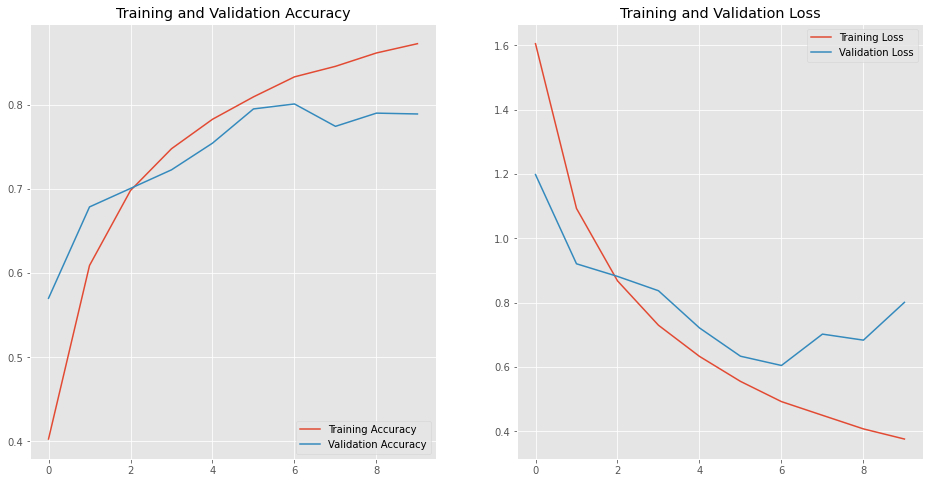

In [10]:
model_dir = '/content/drive/MyDrive/Colab Notebooks/Cifar10'
file_name = "Cifar10-best-model"
logfile = f"{model_dir}/{file_name}_training.log"

def plot_accuracy_loss(file_name):
    import pandas as pd
    log_data = pd.read_csv(file_name)
    acc = log_data['accuracy']
    val_acc = log_data['val_accuracy']
    loss = log_data['loss']
    val_loss = log_data['val_loss']
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(log_data['epoch'], acc, label='Training Accuracy')
    plt.plot(log_data['epoch'], val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(log_data['epoch'], loss, label='Training Loss')
    plt.plot(log_data['epoch'], val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt.show()
plot_accuracy_loss(logfile)

# 找出預測錯誤的圖片

In [11]:
pre = cnn.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, pre))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,0,1,2,3,4,5,6,7,8,9
0,769,14,16,28,15,4,3,2,137,12
1,4,849,3,7,1,3,2,0,43,88
2,55,3,668,74,76,38,43,11,31,1
3,14,4,43,725,51,83,42,15,20,3
4,13,2,45,54,809,19,29,17,9,3
5,5,1,32,205,47,665,17,13,12,3
6,6,3,35,58,32,9,833,1,21,2
7,15,1,34,45,81,49,5,759,8,3
8,21,8,4,9,3,1,2,0,948,4
9,10,39,1,17,3,2,4,5,51,868


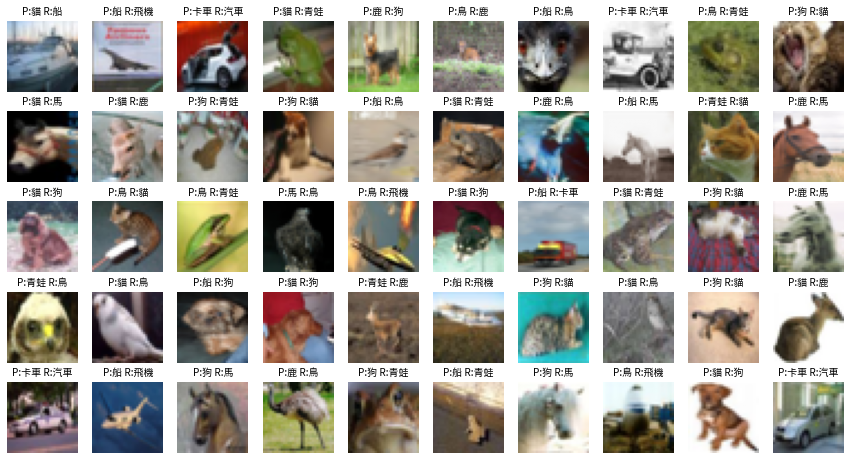

In [12]:
import numpy as np
wrong_list = np.nonzero(pre != y_test.reshape(10000))[0] #預測錯誤列表
right_lable = y_test[wrong_list] #預測錯誤圖片的正確標籤
pre_lable = pre[wrong_list] #預測錯誤圖片的預測標籤
wrong_img = X_test[wrong_list] #錯誤圖片

plt.figure(figsize=(15,350))
width = 10
height = int(len(wrong_img)/10) + 1
for i, img in enumerate(wrong_img[:50]):
  plt.subplot(height, width, i+1)
  plt.axis("off")
  title = f"P:{class_name[pre_lable[i]]} R:{class_name[right_lable[i][0]]}"
  plt.title(title, fontproperties=myfont)
  plt.imshow(img)

# 模型預測
* 不重新訓練模型預測，請先執行cell_1然後執行下方第一格。
* 執行上述過程後，即可直接使用下方第二格進行預測分析。

In [17]:
model_dir = '/content/drive/MyDrive/Colab Notebooks/Cifar10'
file_name = "Cifar10-best-model"
modelfile = f"{model_dir}/{file_name}.h5"
cnn = keras.models.load_model(modelfile)
val, accuracy = cnn.evaluate(X_test/255, y_test)
print(f"損失Loss: {val:.4f}\n評估模型準確度: {accuracy:.4f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.6048 - accuracy: 0.8012
損失Loss: 0.6048
評估模型準確度: 0.8012


預測分類: 鹿


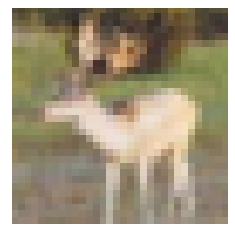

In [20]:
from random import randint
num_random = randint(0,X_train.shape[0]-1)
test_imp = np.expand_dims(X_train[num_random]/255,axis=0)
pred = cnn.predict(test_imp)
print(f"預測分類: {class_name[[np.argmax(pred)][0]]}")
plt.xticks([])
plt.yticks([])
plt.imshow(X_train[num_random])